<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision import datasets
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
import multiprocessing
def get_dataloader(image_size, batch_size, root = 'dataset'):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  #(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
  #0.485, 0.456, 0.406 || 0.229, 0.224, 0.225
  transform = tt.Compose([
                            tt.ToTensor(),
                            tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5],), 
                            tt.Resize(image_size, antialias=True)
                        ])
  
  dataset = datasets.ImageFolder(root, transform=transform)
  max_workers = 6 #multiprocessing.cpu_count() - комп лагает если максимум постваить 

  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=max_workers)

  return dataloader

In [3]:
device = torch.device("cuda")

In [4]:
image_size = 256
batch_size = 16

dataloader = get_dataloader(image_size, batch_size)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [5]:
class ConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, padding = 0, stride = 1, is_last_block=False):
        super().__init__()
        self.is_last_block = is_last_block

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        return x

In [6]:
class PrintModul(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [7]:
discriminator = nn.Sequential(
    # 3 x 64 x 64
    ConvNormBlock(in_channels=3, out_channels=256, kernel_size=3, padding=1),
    nn.MaxPool2d(2, 2),
    # 8 x 32 x 32

    ConvNormBlock(in_channels=256, out_channels=1024, kernel_size=3, padding=1),
    nn.MaxPool2d(2, 2),
    # 16 x 16 x 16

    ConvNormBlock(in_channels=1024, out_channels=2048, kernel_size=3, padding=1),
    nn.MaxPool2d(2, 2),
    # 32 x 8 x 8

    ConvNormBlock(in_channels=2048, out_channels=512, kernel_size=3, padding=1), 
    nn.MaxPool2d(2, 2),
    # 64 x 4 x 4

    ConvNormBlock(in_channels=512, out_channels=128, kernel_size=1),  # тут может быть ошибка 
    #PrintModul(),
    nn.Flatten(),
    
    nn.Linear(128*4*4, 1024),
    nn.Linear(1024, 256),
    nn.Linear(256, 64),
    nn.Linear(64, 16),
    nn.Linear(16, 1),

    nn.Sigmoid()
)

In [8]:
class LinTo(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.latent_size = latent_size
        self.lin = nn.Sequential(
            nn.Flatten(),

            nn.Linear(latent_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, latent_size),
            nn.BatchNorm1d(latent_size),
            nn.ReLU(),
        )
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.lin(x)
        return x.view(batch_size, self.latent_size, 1, 1)

In [9]:
latent_size = 1024

generator = nn.Sequential(
    #nn.Linear(latent_size, latent_size*4),
    #nn.ReLU(),
    #nn.Linear(latent_size*4, latent_size*2),
    #nn.ReLU(),
    #nn.Linear(latent_size*2, latent_size),
    #nn.ReLU(),

    # in: latent_size x 1 x 1
    LinTo(latent_size),
    
    nn.ConvTranspose2d(latent_size, 2048, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(2048),
    nn.ReLU(),
    # out: 512 x 4 x 4

    nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=3, padding=1),
    nn.BatchNorm2d(1024),
    nn.ReLU(),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    # out: 256 x 8 x 8
    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    # out: 128 x 16 x 16

    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    # out: 64 x 32 x 32

    

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
    #############
    #nn.BatchNorm2d(32),
    #nn.ReLU(),
    # out: 32 x 64 x 64

    #nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #nn.Tanh()
    # out: 3 x 128 x 128

)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [10]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
#stats = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [12]:
def show_tensor(img_t, clr_output=True):
    if clr_output:
        clear_output(wait=True)

    #img_t = img_t.permute(1, 2, 0)
    img_t = img_t.cpu()
    
    #plt.figure(figsize=(6, 6))
    plt.plot()
    plt.axis("off")
    plt.imshow(img_t.permute(1, 2, 0))
    plt.title('Generated image')
    plt.show()

In [13]:
def show_tensors(tensors, img_amout=6, clr_output=True):
    if clr_output:
        clear_output(wait=True)

    plt.figure(figsize=(12, 6))

    for i, img in enumerate(tensors):
        if i >= img_amout:
            break
        img = img.cpu()
        mean = stats[0]
        std = stats[1]
        
        t_std = torch.tensor(std).view(3, 1, 1)
        t_mean = torch.tensor(mean).view(3, 1, 1)

        img = img * t_std + t_mean
        plt.subplot(1, img_amout, i+1)
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0).detach().numpy())
        plt.title('Generated')

    plt.show()

Вот так выглядият реальные люди

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


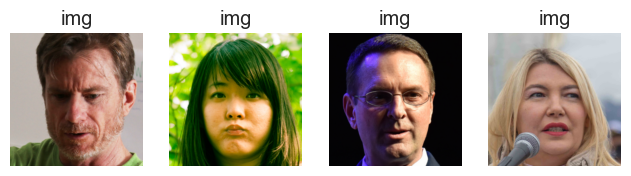

In [16]:
for i, _ in dataloader:
    show_tensors(i[0:4])
    break

In [14]:
latent_size = latent_dim = 100
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            LinTo(latent_dim),

            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 10, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 10),
            nn.ReLU(True),
            
            # Block 2: input is (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 10, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            
            # Block 3: input is (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 8, 64 * 6, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 6),
            nn.ReLU(True),
            
            # Block 4: input is (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 6, 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            
            # Block 5: input is (64) x 32 x 32
            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),

            # Block 5: input is (64) x 64 x 64
            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Block 5: input is (64) x 128 x 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),

            nn.Tanh()
            # Output: output is (3) x 64 x 64
        )
 
    def forward(self, input):
        output = self.main(input)
        return output    
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            # if 256 -> 3x256x256
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Block 2: input is (64) x 32 x 32
            # if 256 -> 64x128x128
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 3: input is (64*2) x 16 x 16
            # if 256 -> 64*2x128x128
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 4: input is (64*4) x 8 x 8
            # if 256 -> 64*4x64x64
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Block 5: input is (64*8) x 4 x 4
            # if 256 -> 64*8x32x32
            nn.Conv2d(64 * 8, 64*10, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 10),
            nn.LeakyReLU(0.2, inplace=True),

            # if 256 -> 64*10x16x16
            nn.Conv2d(64 * 10, 64 * 6, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 6),
            nn.LeakyReLU(0.2, inplace=True),

            # if 256 -> 64*6x8x8
            nn.Conv2d(64 * 6, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # if 256 -> 64*2x4x4
            nn.Conv2d(64 * 2, 1, 4, 2, 1, bias=False),

            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
        )
 
    def forward(self, input):
        output = self.main(input)
        return output

In [15]:
#lr = 0.0001

'''model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}'''
model = {
    "discriminator": Discriminator().to(device),
    "generator": Generator().to(device)
}
criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [16]:
def plot_data(data, title='График данных',):
   
    plt.plot(data)
    plt.title(title)

    plt.grid(True)
    plt.show()


In [17]:

def fit(model, train_dl, criterion, epochs, lr):
  model["discriminator"].train()
  model["generator"].train()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  optimizer = {
      "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                        lr=lr, betas=(0.5, 0.999)),
      "generator": torch.optim.Adam(model["generator"].parameters(),
                                    lr=lr, betas=(0.5, 0.999))
  }

  for epoch in range(epochs):
      loss_d_per_epoch = []
      loss_g_per_epoch = []
      real_score_per_epoch = []
      fake_score_per_epoch = []
      for real_images, _ in tqdm(train_dl):
          # Train discriminator
          # Clear discriminator gradients
          optimizer["discriminator"].zero_grad()

          # Pass real images through discriminator
          #print(real_images.shape)
          real_images = real_images.to(device)

          real_preds = model["discriminator"](real_images)
          real_targets = torch.ones(real_images.size(0), 1, device=device)
          real_loss = criterion["discriminator"](real_preds, real_targets)
          cur_real_score = torch.mean(real_preds).item()
          
          # Generate fake images
          latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          fake_images = model["generator"](latent)
          
          # Pass fake images through discriminator
          fake_targets = torch.zeros(fake_images.size(0), device=device)
          fake_preds = model["discriminator"](fake_images)
          #print('fake preds', fake_preds.squeeze().shape, 'fake targ', fake_targets.shape)
          fake_loss = criterion["discriminator"](fake_preds.squeeze(), fake_targets)
          cur_fake_score = torch.mean(fake_preds).item()

          real_score_per_epoch.append(cur_real_score)
          fake_score_per_epoch.append(cur_fake_score)

          # Update discriminator weights
          loss_d = real_loss + fake_loss
          loss_d.backward()
          optimizer["discriminator"].step()
          loss_d_per_epoch.append(loss_d.item())


          # Train generator
          # Clear generator gradients
          optimizer["generator"].zero_grad()
          
          # Generate fake images
          latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          fake_images = model["generator"](latent)
          
          # Try to fool the discriminator
          preds = model["discriminator"](fake_images)
          targets = torch.ones(batch_size, 1, device=device)
          loss_g = criterion["generator"](preds, targets)
          
          # Update generator weights
          loss_g.backward()
          optimizer["generator"].step()
          loss_g_per_epoch.append(loss_g.item())

          
          
      # Record losses & scores
      losses_g.append(np.mean(loss_g_per_epoch))
      losses_d.append(np.mean(loss_d_per_epoch))
      real_scores.append(np.mean(real_score_per_epoch))
      fake_scores.append(np.mean(fake_score_per_epoch))
      
      #show generated images
      #show_images(fake_images.cpu())

      # Log losses & scores (last batch)
      show_tensors(fake_images[:4].cpu(), clr_output=True)
      print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, epochs, 
          losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
      
      
      
      # Save generated images
      '''if epoch == epochs - 1:
        save_samples(epoch+start_idx, fixed_latent, show=False)'''

  return losses_g, losses_d, real_scores, fake_scores

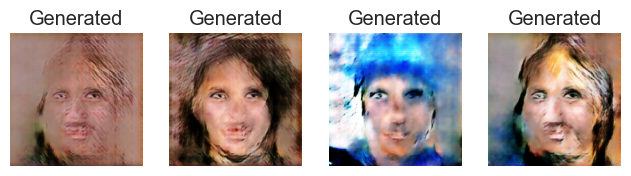

Epoch [30/30], loss_g: 4.5326, loss_d: 0.6718, real_score: 0.7760, fake_score: 0.2231


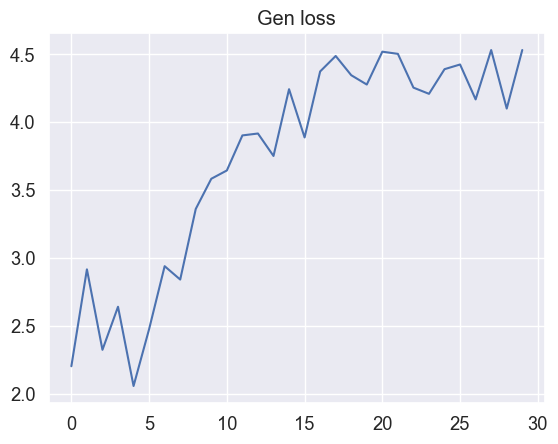

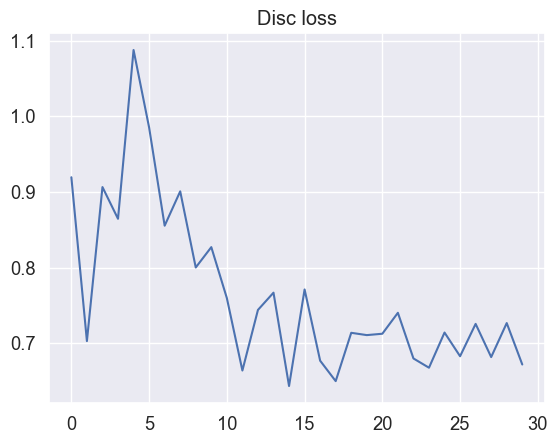

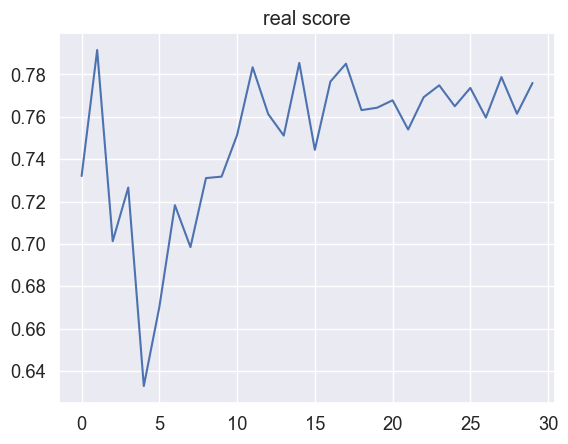

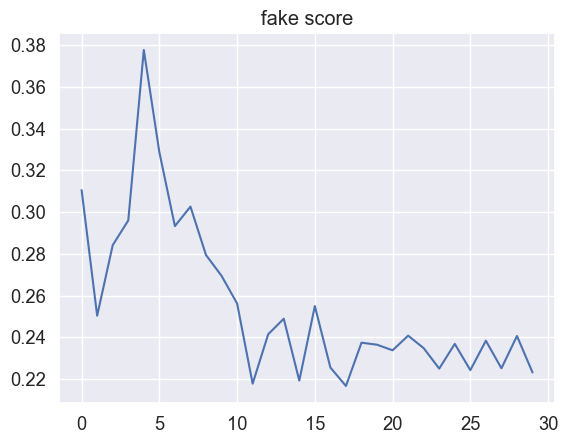

In [18]:
#model, train_dl, criterion, epochs, lr
history = fit(model, train_dl=dataloader, criterion=criterion, epochs=30, lr=3e-4)
for name, data in zip(['Gen loss', 'Disc loss', 'real score', 'fake score'], history):
    plot_data(data, title=name)
save_path = 'my_gen_256.pth'
torch.save(model['generator'].state_dict(), save_path)
save_path = 'my_dis_256.pth'
torch.save(model['discriminator'].state_dict(), save_path)

лосс генератора возрастает, возможно генератор не успевает за дискриминатором  
fake score так же не растет после 5 эпох 

In [17]:

model['generator'].load_state_dict(torch.load('my_gen.pth'))
model['generator'].eval()

model['discriminator'].load_state_dict(torch.load('my_dis.pth'))
model['discriminator'].eval()


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Уже описал выше 

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [30]:
n_images = 5

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

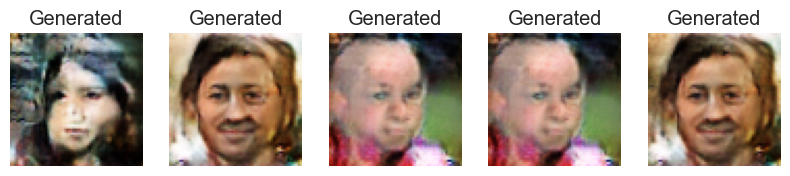

In [31]:
show_tensors(fake_images.cpu(), clr_output=True)


Как вам качество получившихся изображений?

выглядит страшно

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Сгенерим

In [32]:
print(len(dataloader.dataset))

3143


In [33]:
n_img = len(dataloader.dataset)

n_latent = torch.randn(n_img, latent_size, 1, 1, device=device)
fake_images = model["generator"](n_latent)

Тепрь преобразуем данные что бы их можно было скормить sklearn 

In [41]:
# красивый способ достать все изображения я не нашел, так что вот
all_images = []
# нужен что бы подошел в кнн
fl = nn.Flatten()
for images, _ in dataloader:
    all_images.append(fl(images).to('cpu'))

all_images.append(fl(fake_images).to('cpu'))

In [42]:
# Создание меток для фейковых и реальных изображений
real_labels = np.ones(n_img)
fake_labels = np.zeros(n_img)

#all_images_tensor = torch.cat(all_images, dim=0)
# Объединение реальных и фейковых изображений и меток
all_images = torch.cat(all_images, dim=0).detach().numpy()
all_labels = np.concatenate([real_labels, fake_labels])

# Преобразование данных в тензоры PyTorch
#all_images = torch.from_numpy(all_images)
#all_labels = torch.from_numpy(all_labels)

In [43]:
print(real_labels.shape, fake_labels.shape)

(3143,) (3143,)


In [44]:
print(all_images.shape)
print(all_labels.shape)

(6286, 12288)
(6286,)


In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(all_images)

print(tsne_result.shape)

(6286, 2)


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score


knn_classifier = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

accuracies = [] 

for train_index, test_index in loo.split(tsne_result):
    X_train, X_test = tsne_result[train_index], tsne_result[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

    # Обучение 1NN Classifier
    knn_classifier.fit(X_train, y_train)
    
    y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Средняя точность leave-one-out
average_accuracy = np.mean(accuracies)
print(f"Средняя точность leave-one-out: {average_accuracy}")

Средняя точность leave-one-out: 0.9928412344893414


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Точность получилась высокой, что означает, что классификатор хорошо отделяе сегенрированные данные от реальных. Значит нужно улучшить качество генерации(что, собственно, видно и не вооруженным взглядом)   
Точность хотелось бы ниже, что означало бы, что качество генерации выросло

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

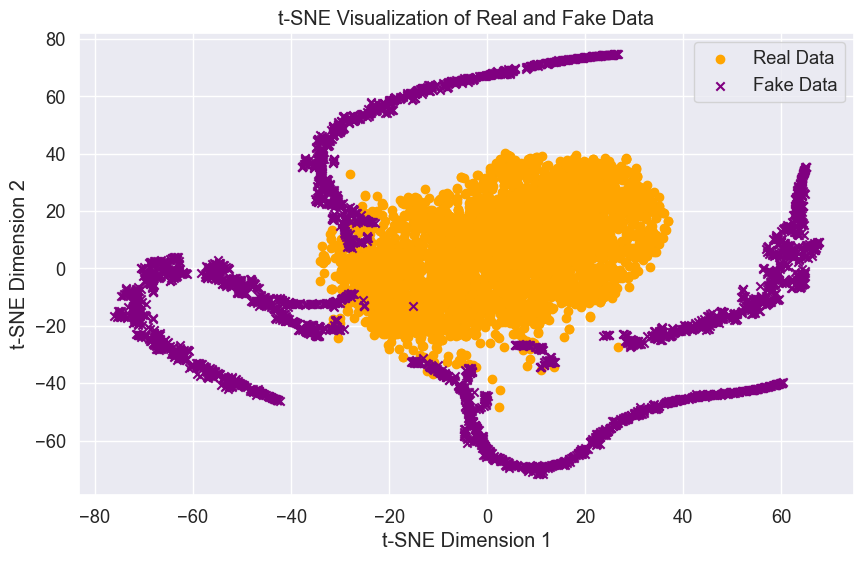

In [48]:
import matplotlib.pyplot as plt

colors = ['purple', 'orange']

real_data = tsne_result[:n_img]
fake_data = tsne_result[n_img:]

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(real_data[:, 0], real_data[:, 1], c=colors[1], marker='o', label='Real Data')
plt.scatter(fake_data[:, 0], fake_data[:, 1], c=colors[0], marker='x', label='Fake Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('t-SNE Visualization of Real and Fake Data')
plt.show()

Получился паук  

Прокомментируйте получившийся результат:

Как можно понять из граффика - настоящие и сгенерированные изображения от сильно отличаются, а так же что раельные данные более однородные(собрались в облако), в отличии от сгенерированных(ноги паука). Тут мы так же убедились, что качество генерации изображений оставляет желать лучшего 